## Challenge 1-1: Custom Vision API – compact model

Create a classification model using a portion of the gear catalog images for hard-shell jackets and insulated jackets using Azure Custom Vision [https://customvision.ai] Compact domain. Download the model and run in locally. 
Docs: [https://docs.microsoft.com/en-us/azure/cognitive-services/custom-vision-service/export-model-python]


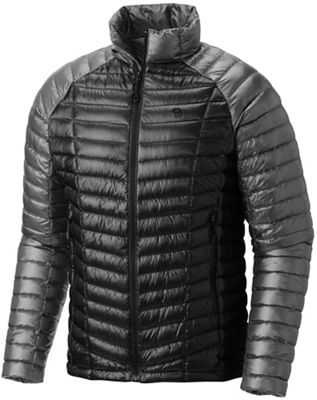

Classified as: insulated

hardshell 0.0
insulated 1.0


In [5]:
#
# aiworkshop challange 1.1. Run downloaded model from Custom Vision
#

from IPython.display import Image
import tensorflow as tf
import os
from PIL import Image as Im
import numpy as np
import cv2

testimg = "data/ch1-1test.jpeg"
model_file = "cs_model.pb"
labels_file = "data/cs_labels.txt"

# Display picture to recognize
display(Image(filename=testimg, width=300, height=300))

#
# Load saved Tensorflow model
#
graph_def = tf.GraphDef()
labels = []

# Import the TF graph
with tf.gfile.FastGFile(model_file, 'rb') as f:
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

# Create a list of labels.
with open(labels_file, 'rt') as lf:
    for l in lf:
        labels.append(l.strip())
        
#
# Image preparation helper functions
#
def convert_to_opencv(image):
    # RGB -> BGR conversion is performed as well.
    r,g,b = np.array(image).T
    opencv_image = np.array([b,g,r]).transpose()
    return opencv_image

def crop_center(img,cropx,cropy):
    h, w = img.shape[:2]
    startx = w//2-(cropx//2)
    starty = h//2-(cropy//2)
    return img[starty:starty+cropy, startx:startx+cropx]

def resize_down_to_1600_max_dim(image):
    h, w = image.shape[:2]
    if (h < 1600 and w < 1600):
        return image

    new_size = (1600 * w // h, 1600) if (h > w) else (1600, 1600 * h // w)
    return cv2.resize(image, new_size, interpolation = cv2.INTER_LINEAR)

def resize_to_256_square(image):
    h, w = image.shape[:2]
    return cv2.resize(image, (256, 256), interpolation = cv2.INTER_LINEAR)

def update_orientation(image):
    exif_orientation_tag = 0x0112
    if hasattr(image, '_getexif'):
        exif = image._getexif()
        if (exif != None and exif_orientation_tag in exif):
            orientation = exif.get(exif_orientation_tag, 1)
            # orientation is 1 based, shift to zero based and flip/transpose based on 0-based values
            orientation -= 1
            if orientation >= 4:
                image = image.transpose(Image.TRANSPOSE)
            if orientation == 2 or orientation == 3 or orientation == 6 or orientation == 7:
                image = image.transpose(Image.FLIP_TOP_BOTTOM)
            if orientation == 1 or orientation == 2 or orientation == 5 or orientation == 6:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
    return image             
        
#
# Open and prepare the image for prediction
#

image = Im.open(testimg)

# Update orientation based on EXIF tags, if the file has orientation info.
image = update_orientation(image)

# Convert to OpenCV format
image = convert_to_opencv(image)
    
# If the image has either w or h greater than 1600 we resize it down respecting
# aspect ratio such that the largest dimension is 1600
image = resize_down_to_1600_max_dim(image)

# We next get the largest center square
h, w = image.shape[:2]
min_dim = min(w,h)
max_square_image = crop_center(image, min_dim, min_dim)

# Resize that square down to 256x256
augmented_image = resize_to_256_square(max_square_image)

# The compact models have a network size of 227x227, the model requires this size.
network_input_size = 227

# Crop the center for the specified network_input_Size
augmented_image = crop_center(augmented_image, network_input_size, network_input_size)

#
# Make prediction and display the results
#
# These names are part of the model and cannot be changed.
output_layer = 'loss:0'
input_node = 'Placeholder:0'

with tf.Session() as sess:
    prob_tensor = sess.graph.get_tensor_by_name(output_layer)
    predictions, = sess.run(prob_tensor, {input_node: [augmented_image] })

    # Print the highest probability label
    highest_probability_index = np.argmax(predictions)
    print('Classified as: ' + labels[highest_probability_index])
    print()

    # Print out all of the results mapping labels to probabilities.
    label_index = 0
    for p in predictions:
        truncated_probablity = np.float64(round(p,8))
        print (labels[label_index], truncated_probablity)
        label_index += 1